In [1]:
import plotting
import importlib
importlib.reload(plotting)
import scipy
import numpy as np
import transforms
import sampling
import matplotlib.pyplot as plt
import sys
#np.set_printoptions(suppress=True)
import chernoff
from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize)

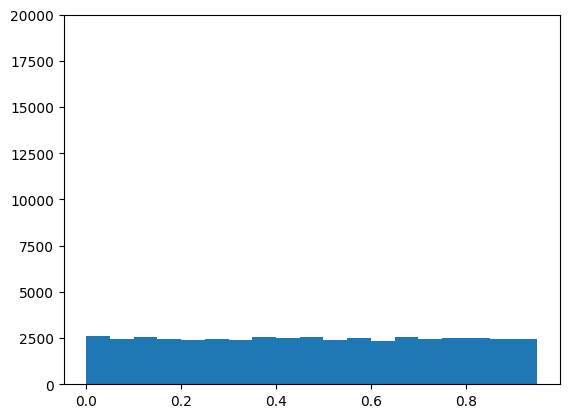

In [5]:
ga,gb = 0.5,1
pi = 0.1
n = 500
rho = 0.2
#for n in [64,128,256,512,1024,2048,4096]:
gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [ga,0,1/gb])
model = sampling.WSBM(f"$\Gamma[{ga},{gb}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))


graph = model.sample(n, rho)

#graph.transform(lambda x : new_transform(1,x))
#graph.transform(lambda x : transforms.PowerTransform.apply(10,x))
XX = graph.graph.flatten()
delt = np.max(XX) - np.min(XX)
bins = np.arange(np.min(XX), np.max(XX), delt/20)
plt.hist(graph.graph.flatten(), bins)
plt.ylim(0, 20_000)
plt.show()

In [10]:
graph = model.sample(n, rho)

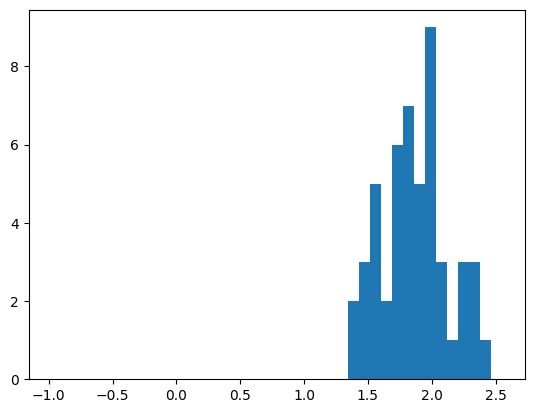

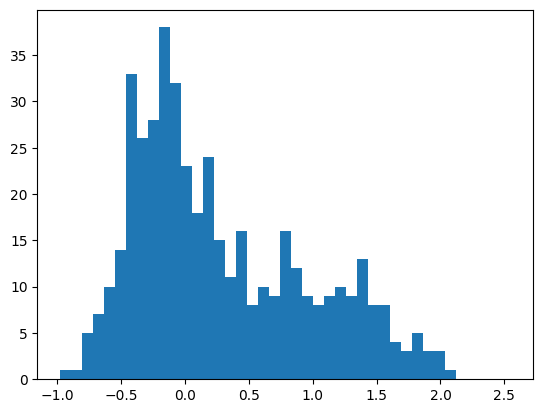

2.2806061637733688


In [13]:
def top_avg(tg, i, j, m = 20):
    topsi = np.sort(tg[i][tg[i] != 0.999])[:m]
    topsj = np.sort(tg[j][tg[j] != 0.999])[:m]
    return np.mean(np.concatenate((topsi, topsj)))

tg = np.copy(graph.graph)
svd_1d = sampling.SpecEmbed(d=1)
for i in range(len(tg)):
    for j in range(len(tg)):
        if graph.graph[i][j] == 0.999:
            if graph.graph[j][i] != 0.999: tg[i][j] = tg[j][i]
            else:
                tg[i][j] = tg[j][i] = top_avg(tg,i,j,5)#(tg3[i][j] / np.linalg.norm(tg3[i])) * np.linalg.norm(tg[i])

tg = -np.log(tg)
tg -= np.mean(tg)
            
sums = svd_1d.fit_transform(tg, True).T[0]

delt = np.max(sums) - np.min(sums)
bins = np.arange(np.min(sums), np.max(sums) + delt/39, delt/40)
plt.hist(sums[:int(pi * n)], bins)
plt.show()
plt.hist(sums[int(pi * n):], bins)
plt.show()
print (chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))

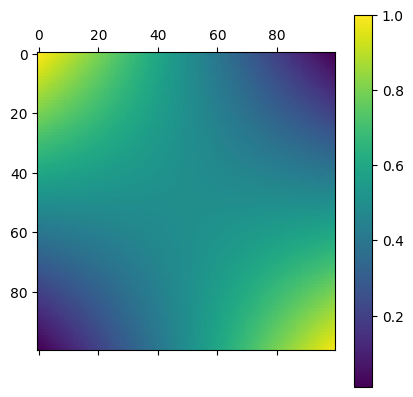

In [4]:
DIS = np.zeros((100,100), dtype="float32")

def iterate_shared(A):
    Aold = np.copy(A)
    for i in range(len(A)):
        for j in range(len(A)):
            cell_sum = 0
            for k in range(len(A)):
                cell_sum += (Aold[i][k] * Aold[j][k]) + ((1 - Aold[i][k]) * (1 - Aold[j][k]))
            A[i][j] = cell_sum / len(A)

# given NOT CONNECTED
def p_null_(i,j,observations):
    return observations[i][j]

# given CONNECTED
def p_alt_(i,j,observations):
    return scipy.stats.gamma.cdf(observations[i][j], *[ga,0,1/gb])

P_ALT, P_NULL = np.array(1), np.array(1)

def p_null(i,j,observations):
    global P_ALT, P_NULL
    return P_NULL[i][j]

def p_alt(i,j,observations):
    global P_ALT, P_NULL
    return P_ALT[i][j]

def iterate_priors(A, observations):
    priors = np.copy(A)
    for i in range(len(A)):
        for j in range(len(A)):
            alpha = 1.0
            for k in range(len(A)):
                if A[i][k] == 1 or A[j][k] == 1: continue
                alpha /= p_alt(i,k,observations) * p_alt(j,k,observations) * priors[i][k] + p_null(i,k,observations) * p_null(j,k,observations) * (1 - priors[i][k])
                alpha *= p_alt(i,k,observations) * p_null(j,k,observations) * priors[i][k] + p_null(i,k,observations) * p_alt(j,k,observations) * (1 - priors[i][k])
            A[i][j] = 1/(1 + alpha * ((1-priors[i][j])/priors[i][j]))
            print (A[i][j], alpha * ((1-priors[i][j])/priors[i][j]))
            A[i][j] = alpha * ((1-priors[i][j])/priors[i][j])
            #A[i][j] *= 100000
def init_priors(pi, observations):
    global P_NULL,P_ALT
    A = np.zeros(observations.shape)
    pri = pi * pi + (1 - pi) * (1 - pi)
    P_NULL,P_ALT = np.zeros(observations.shape), np.zeros(observations.shape)
    for i in range(len(A)):
        for j in range(len(A)):
            P_NULL[i][j] = p_null_(i,j,observations)
            P_ALT[i][j] = p_alt_(i,j,observations)
            
    for i in range(len(A)):
        for j in range(len(A)):
            marg = p_alt(i,j,observations) * pri + p_null(i,j,observations) * (1 - pri)
            A[i][j] = p_alt(i,j,observations) * pri / marg
    return A    

for x in range(100):
    for y in range(100):
        DIS[x][y]= (x/100)*(y/100)+ (1 - x/100)*(1 - y/100)
        
def iterate_one_tailed(A, p_values, alt_dist):
    priors = np.copy(A)
    alpha = (1-pi)/((1-pi) + (1 - pi) - ((1 - pi)**2))
    for i in range(len(A)):
        for j in range(len(A)):
            mult = p_values[i] * ((1 - pi) * p_values[j] + pi * alt_dist.cdf(p_values[i], *[ga,0,1/gb]))
            A[i][j] = A[i][j] * mult
            for k in range(len(A)):
                if A[i][k] == 1 or A[j][k] == 1: continue
                alpha /= p_alt(i,k,observations) * p_alt(j,k,observations) * priors[i][k] + p_null(i,k,observations) * p_null(j,k,observations) * (1 - priors[i][k])
                alpha *= p_alt(i,k,observations) * p_null(j,k,observations) * priors[i][k] + p_null(i,k,observations) * p_alt(j,k,observations) * (1 - priors[i][k])
            A[i][j] = 1/(1 + alpha * ((1-priors[i][j])/priors[i][j]))
            print (A[i][j], alpha * ((1-priors[i][j])/priors[i][j]))
            A[i][j] = alpha * ((1-priors[i][j])/priors[i][j])
            #A[i][j] *= 100000
plt.matshow(DIS)
plt.colorbar()

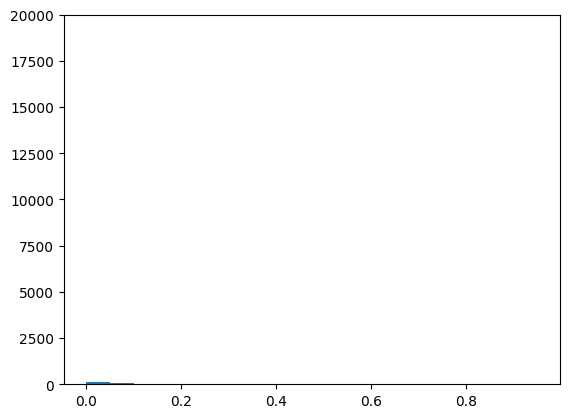

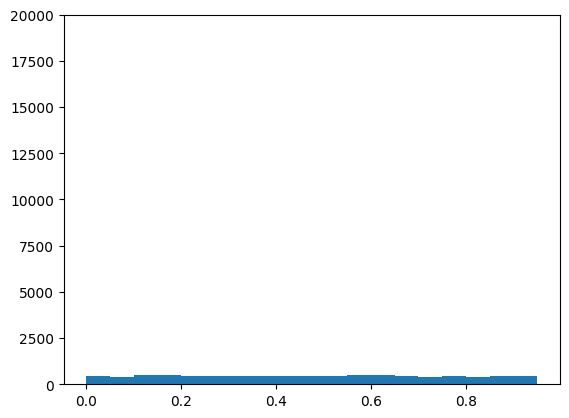

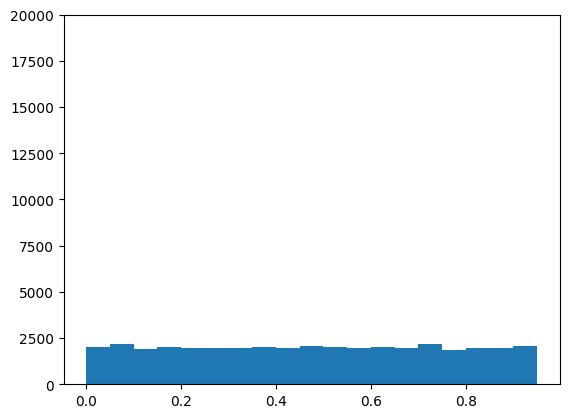

In [5]:
npi = int(n * pi)
h1_h1 = graph.graph[:npi, :npi].flatten()
h1_h0 = np.concatenate((graph.graph[:npi, npi:].flatten(), graph.graph[npi:, :npi].flatten()))
h0_h0 = graph.graph[npi:, npi:].flatten()

plt.hist(h1_h1, bins)
plt.ylim(0,20_000)
plt.show()
plt.hist(h1_h0, bins)
plt.ylim(0,20_000)
plt.show()
plt.hist(h0_h0, bins)
plt.ylim(0,20_000)
plt.show()

In [6]:
#graph.untransform()15

In [7]:
#graph.untransform()
#sums = np.sum(np.sort(graph.graph)[:, :250], axis = 1)
n_pi = 10
ress = []
for ppi in tqdm(range(1,n_pi + 1)):
    ppi = ppi / n_pi
    tg = np.copy(graph.graph)
    for i in range(len(tg)):
        for j in range(len(tg)):
            if tg[i][j] >= 0.999:
                tg[i][j] = 0; continue
            #print (tg[i][j], scipy.stats.gamma.pdf(tg[i][j], *[ga,0,1/gb]))
            tg[i][j] = scipy.stats.gamma.pdf(tg[i][j], *[ga,0,1/gb]) * ppi + (1 - ppi) * tg[i][j]
            if tg[i][j] < 1e-6: tg[i][j] = 1e-6
            tg[i][j] = -np.log(tg[i][j])
           #print (tg[i][j])

    sums = np.sum(tg, axis = 1)
    sums /= np.array([len(tg[i][tg[i] != 0]) for i in range(len(tg))])
    #print (sums[:10])
    delt = np.max(sums) - np.min(sums)
    #print (delt)
    bins = np.arange(np.min(sums), np.max(sums), delt/20)
    #plt.hist(sums[:int(pi * n)], bins)
    #plt.show()
    #plt.hist(sums[int(pi * n):], bins)
    #plt.show()
    ress.append(chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))
    #plt.matshow(tg, vmin = 0, vmax = 5)
    #plt.colorbar()
if x_[j][i] != 0.999: x_[i][j] = x_[j][i]
                else:
plt.plot([i / n_pi for i in range(1,n_pi + 1)], ress)

IndentationError: unexpected indent (1949507145.py, line 32)

In [ ]:
tg = np.copy(graph.graph)
tg = tg - np.mean(tg, axis = 0)
cov = (tg.T @ tg) / len(tg)

vars = np.std(tg, axis = 0)
varm = np.zeros((len(tg),len(tg)))
for i in range(len(tg)):
    for j in range(len(tg)):
        varm = vars[i] * vars[j]

cor = cov / varm
sums = np.zeros(len(tg))
for i in range(len(tg)):
    sums[i] = np.sum(np.log(np.sort(cor[i])[-50:-2]))
#sums = np.sum(tg, axis = 1)
delt = np.max(sums) - np.min(sums)
bins = np.arange(np.min(sums), np.max(sums), delt/20)
plt.hist(sums[:int(pi * n)], bins)
plt.show()
plt.hist(sums[int(pi * n):], bins)
plt.show()
print (chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))
plt.matshow(cor, vmin = 0, vmax = 0.5)
plt.colorbar()

In [ ]:
def simplified_belief_prop(A, alt_dist, null_dist, alt_prob, N = 10):
    # NOT WORKING
    alt_densities = alt_dist(A)
    null_densities = null_dist(A)
    marginal_densities = alt_prob * alt_densities + (1 - alt_prob) * null_densities
    M1 = np.ones(len(A)) * pi
    M0 = np.ones(len(A)) * (1-pi)
    for _ in tqdm(range(N)):
        nu1 = np.ones(len(A))
        for i in range(len(A)):
            for j in range(len(A)):
                if A[i][j] == 0.999: continue
                nu1[i] *= pi / marginal_densities[i][j]
                nu1[i] *= alt_densities[i][j] * pi * M1[j] + null_densities[i][j] * (1 - pi) * M0[j]
        nu0 = np.ones(len(A))
        for i in range(len(A)):
            for j in range(len(A)):
                if A[i][j] == 0.999: continue
                nu0[i] *= (1 - pi) / marginal_densities[i][j]
                nu0[i] *= null_densities[i][j] * pi * M1[j] + null_densities[i][j] * (1 - pi) * M0[j]
        print (nu1[:10], nu0[:10])
        M1 = nu1 / (nu1 + nu0)
        print (M1[:10])
        M0 = nu0 / (nu1 + nu0)      
    return M1

def belief_prop(A, alt_dist, null_dist, alt_prob, N = 10):
    alt_densities = alt_dist(A)
    null_densities = null_dist(A)
    marginal_densities = alt_prob * alt_densities + (1 - alt_prob) * null_densities
    M1 = np.ones((len(A), len(A))) * pi
    M0 = np.ones((len(A), len(A))) * (1-pi)
    for _ in tqdm(range(N)):
        nu1 = np.ones((len(A), len(A)))
        nu0 = np.ones((len(A), len(A)))
        for i in range(len(A)):
            for j in range(len(A)):
                # this is the message which node i sends to its neighbour j
                if A[i][j] == 0.999: continue
                mult = 1#pi / marginal_densities[i][j]
                mult *= alt_densities[i][j] * pi * M1[j][j] + null_densities[i][j] * (1 - pi) * M0[j][j]
                for k in range(len(A)):
                    if k != j: nu1[i][k] *= mult
                mult = 1#(1-pi) / marginal_densities[i][j]
                mult *= null_densities[i][j] * pi * M1[j][j] + null_densities[i][j] * (1 - pi) * M0[j][j]
                for k in range(len(A)):
                    if k != j: nu0[i][k] *= mult
    FIN1 = np.ones(len(A))
    FIN0 = np.ones(len(A))
    for i in range(len(A)):
        for j in range(len(A)):
            # this is the message which node i sends to its neighbour j
            if A[i][j] == 0.999: continue
            mult = pi / marginal_densities[i][j]
            mult *= alt_densities[i][j] * pi * M1[j][j] + null_densities[i][j] * (1 - pi) * M0[j][j]

            mult2 = (1-pi) / marginal_densities[i][j]
            mult2 *= null_densities[i][j] * pi * M1[j][j] + null_densities[i][j] * (1 - pi) * M0[j][j]
            FIN1[i] *= mult2/max(1e-20,mult)
    
        if FIN1[i] > np.median(FIN1) * 2: FIN1[i] = np.median(FIN1) * 2
    return FIN1


def variant_belief_prop_embed(A, alt_dist, null_dist, alt_prob, N = 10):
    alt_densities = alt_dist(A)
    null_densities = null_dist(A)
    M = np.ones(len(A)) * pi
    joint0 = np.ones(len(A))
    joint1 = np.ones(len(A))
    factors = np.ones((len(A),len(A)))
    for _ in tqdm(range(N)):
        joint1 = np.ones(len(A))
        for j in range(len(A)):
            for i in range(len(A)):
                if A[i][j] == 0.999: continue
                CM = M[i]
                cfactor = (1 - CM) + alt_densities[i][j] * CM
                joint1[j] *= cfactor
                factors[j][i] = cfactor
            M[j] = joint1[j] * pi / (joint1[j] * pi + joint0[j] * (1 - pi))
    ret = joint0 / joint1


    tg = A
    mu = np.mean(A)

    cov = np.zeros((len(tg), len(tg)))
    for i in tqdm(range(len(tg))):
        for j in range(len(tg)):
            cnt = 0
            for k in range(len(tg)):
                if (A[i][k] == 0.999 or A[j][k] == 0.999): continue
                cov[i][j] += (A[i][k] - mu) * (A[j][k] - mu)
                cnt += 1
            if cnt > 0: cov[i][j] /= cnt
                
    vars = np.std(tg, axis = 0)
    varm = np.zeros((len(tg),len(tg)))
    for i in (range(len(tg))):
        for j in range(len(A)):
            varm = vars[i] * vars[j]
    cor = cov / varm - np.eye(len(tg))
    
    for i in range(len(A)):
        if ret[i] > CUTOFF: ret[i] = CUTOFF
    
    final = np.zeros((len(ret), 2))
    for i in range(len(A)):
        final[i][0] = ret[i]
        final[i][1] = ret[np.argmax(cor[i])]
    return final


def variant_belief_prop(A, alt_dist, null_dist, alt_prob, N = 10):
    alt_densities = alt_dist(A)
    null_densities = null_dist(A)
    M = np.ones(len(A)) * pi
    joint0 = np.ones(len(A))
    joint1 = np.ones(len(A))

    joint1_ = np.ones(len(A))
    factors = np.ones((len(A),len(A)))
    for iter in tqdm(range(N)):
        joint1 = np.ones(len(A))
        for j in range(len(A)):
            for i in range(len(A)):
                if A[i][j] == 0.999 or i == j: continue
                CM = M[i]
                #if iter > 0: 
                #    cj = (M[i] * (joint1_[i] * pi + joint0[i] * (1 - pi))) / pi
                #    cj /= factors[i][j]
                #    CM = cj# * pi / (cj * pi + joint0[j] * (1 - pi))
                cfactor = (1-CM)+ alt_densities[i][j] * CM
                joint1[j] = joint1[j] * cfactor
                #factors[j][i] = cfactor
            M[j] = joint1[j] * pi / (joint1[j] * pi + joint0[j] * (1 - pi))
        #joint1_ = np.copy(joint1)
    ret = joint0 / joint1
    for i in range(len(tg)):
        if ret[i] > CUTOFF: ret[i] = CUTOFF
    return ret

CUTOFF = 20
true_0 = np.concatenate((np.zeros(int(n * pi)), np.ones(n - int(n * pi)))).reshape(1, -1)
true_1 = np.concatenate((np.ones(int(n * pi)), np.zeros(n - int(n * pi)))).reshape(1, -1)

In [ ]:
def gen_folds(transform, classifier, N = 3, norm = True, local_rho = None):
    if local_rho is None: local_rho = rho
    R = np.zeros((N, n))
    for fold in range(N):
        local_graph = model.sample(n, local_rho)
        tg = transform(local_graph.graph)
        R[fold] = classifier(tg)
        if norm:
            R[fold] -= np.min(R[fold])
            if np.max(R[fold]) != 0: R[fold] /= np.max(R[fold])
    return R

def gen_folds_granular(transform, classifier, N_gran = 10, N = 3, norm = True):
    R = np.zeros((N_gran, N, n))
    for gran in range(1,N_gran + 1):
        R[gran - 1] = gen_folds(transform, classifier, N, norm, gran / N_gran)
    return R

In [ ]:
def top_avg(tg, i, j, m = 20):
    topsi = np.sort(tg[i][tg[i] != 0.999])[:m]
    topsj = np.sort(tg[j][tg[j] != 0.999])[:m]
    return np.mean(np.concatenate((topsi, topsj)))


In [ ]:
tg = np.copy(graph.graph)
for i in range(len(tg)):
    for j in range(len(tg)):
        if graph.graph[i][j] == 0.999:
            if graph.graph[j][i] != 0.999: tg[i][j] = tg[j][i]
            else:
                tg[i][j] = tg[j][i] = top_avg(tg,i,j)

100%|██████████| 2/2 [00:00<00:00, 16.82it/s]


0.0004496161159823415 20.0 19.999550383884017


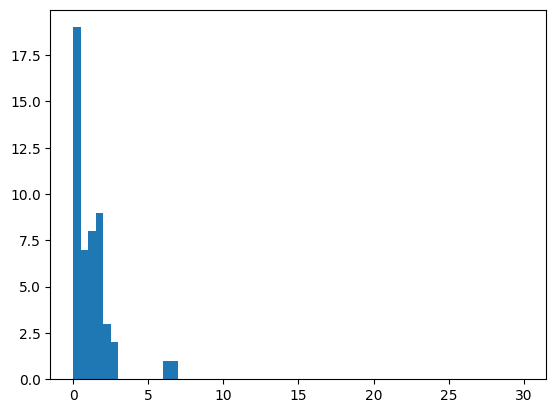

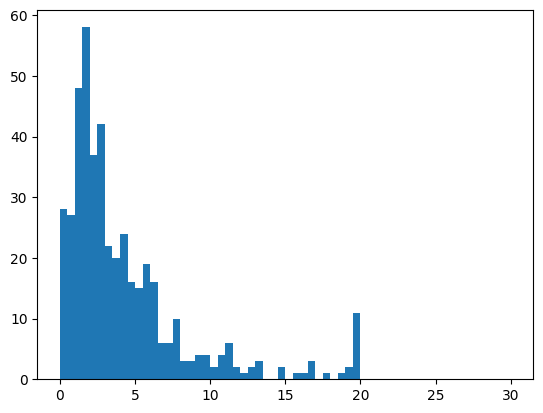

0.7717095030630475


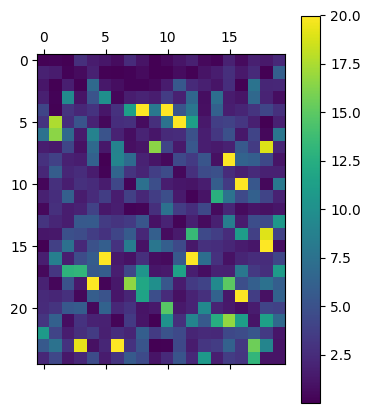

In [ ]:
tg = np.copy(graph.graph)
#tg = -np.log(tg)
#graph.transform(lambda x : transforms.FisherTransform.apply(0,x))
alt_dist_fn = lambda x : scipy.stats.gamma.pdf(x, *[ga,0,1/gb])
null_dist_fn = lambda x : np.ones(x.shape)
#for i in range(len(tg)):
#    for j in range(len(tg)):
#        if graph.graph[i][j] == 0.999:
#            if graph.graph[j][i] != 0.999: tg[i][j] = tg[j][i]
#            else:
#                tg[i][j] = tg[j][i] = top_avg(tg,i,j)

sums = variant_belief_prop(tg, alt_dist_fn, null_dist_fn, pi * pi, 2)
classify_lambda = lambda tg : variant_belief_prop(tg, alt_dist_fn, null_dist_fn, pi * pi, 2)
#SUMS = gen_folds_granular(lambda x : x, classify_lambda,N=3)

delt = np.max(sums)- np.min(sums)
print (np.min(sums),np.max(sums), delt)
bins = np.arange(np.min(sums), np.max(sums) + 10, delt/40)
#print (sums)
plt.hist(sums[:int(pi * n)], bins)
plt.show()
plt.hist(sums[int(pi * n):], bins)
plt.show()
print (chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))
plt.matshow(sums.reshape(-1, 20))
plt.colorbar()

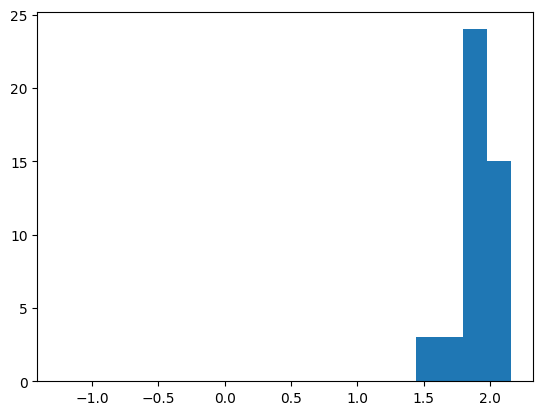

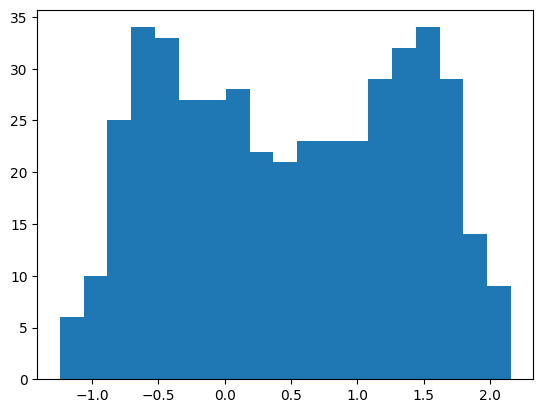

2.1972245763375695


In [ ]:
tg = np.copy(graph.graph)
importlib.reload(sampling)
svd_1d = sampling.SpecEmbed(d=1)
for i in range(len(tg)):
    for j in range(len(tg)):
        if graph.graph[i][j] == 0.999:
            if graph.graph[j][i] != 0.999: tg[i][j] = tg[j][i]
            else:
                tg[i][j] = tg[j][i] = top_avg(tg,i,j,5)#(tg3[i][j] / np.linalg.norm(tg3[i])) * np.linalg.norm(tg[i])

tg = -np.log(tg)
tg -= np.mean(tg)
            
sums = svd_1d.fit_transform(tg, True).T[0]

delt = np.max(sums) - np.min(sums)
bins = np.arange(np.min(sums), np.max(sums), delt/20)
plt.hist(sums[:int(pi * n)], bins)
plt.show()
plt.hist(sums[int(pi * n):], bins)
plt.show()
print (chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))

In [ ]:

classify_lambda = lambda tg : svd_1d.fit_transform(tg, True).T[0]
def transform_centered_(x_, centered = True):
    x = np.copy(x_)
    for i in range(len(x_)):
        for j in range(len(x_)):
            if x_[i][j] == 0.999:
                if x_[j][i] != 0.999: x[i][j] = x[j][i]
                else:
                    x[i][j] = top_avg(x_,i,j,5)
    x = -np.log(x)
    if centered: x -= np.mean(x)
    return x

def transform_centered(x_, centered = True):
    x = -np.log(x_)
    for i in range(len(x)):
        for j in range(len(x)):
            if x_[i][j] == 0.999:
                if x_[j][i] != 0.999: x[i][j] = x[j][i]
                else:
                    x[i][j] = 0
    if centered: x -= np.mean(x)
    return x
#SUMS2 = gen_folds_granular(lambda x : transform_centered_(x,True), classify_lambda, N = 2)


In [ ]:
import plotting
importlib.reload(plotting)
%matplotlib widget

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X1,Y1,Z1=plotting.ROC_surface_data(np.repeat(np.repeat(true_0,3,axis=0).reshape(1,3,-1),10,axis=0), SUMS)
X2,Y2,Z2=plotting.ROC_surface_data(np.repeat(np.repeat(true_0,3,axis=0).reshape(1,3,-1),10,axis=0), SUMS2)

#ax.plot_surface(X1,Y1,Y1*0)
ax.set(
    xlabel="edge probability", ylabel="false positive rate", zlabel="true positive rate"
)
plotting.plot_ROC_surface(X1,Y1,Z2 - Z1, "Advantage of V-MP over Spectral embedding, $\\Gamma(0.2,0.5)$",fig,ax,plotting.cm.get_cmap('bwr_r'))
plt.show()

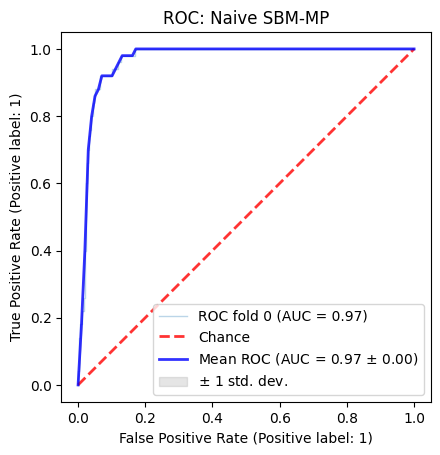

In [ ]:
plotting.ROC_plot(np.repeat(true_0,3,axis=0), sums.reshape(1,-1), "Naive SBM-MP")

In [ ]:
for rhoo in [0,1,2,3]:
    plotting.ROC_plot(np.repeat(true_0,3,axis=0), SUMS[rhoo], f"V-MP $\\rho = 0.{rhoo + 1}$")
    plotting.ROC_plot(np.repeat(true_0,3,axis=0), SUMS2[rhoo], f"Spectral embedding, centered $\\rho = 0.{rhoo + 1}$")

In [ ]:
sums

In [ ]:
#graph.untransform()
#sums = np.sum(np.sort(graph.graph)[:, :250], axis = 1)
n_pi = 20
ress = []
for ppi in tqdm(range(1,n_pi+1)):
    ppi = ppi / n_pi
    tg = np.copy(graph.graph)
    for i in range(len(tg)):
        for j in range(len(tg)):
            if tg[i][j] >= 0.999:
                tg[i][j] = 0; continue
            #print (tg[i][j], scipy.stats.gamma.pdf(tg[i][j], *[ga,0,1/gb]))
            tg[i][j] = scipy.stats.gamma.pdf(tg[i][j], *[ga,0,1/gb]) * ppi + (1 - ppi)
            #print (scipy.stats.gamma.pdf(tg[i][j], *[ga,0,1/gb]) * ppi, (1 - ppi))
            if tg[i][j] < 1e-6: tg[i][j] = 1e-6
            tg[i][j] = -np.log(tg[i][j])
           #print (tg[i][j])

    sums = np.sum(tg, axis = 1)
    sums /= np.array([len(tg[i][tg[i] != 0]) for i in range(len(tg))])
    #print (sums[:10])
    delt = np.max(sums) - np.min(sums)
    #print (delt)
    bins = np.arange(np.min(sums), np.max(sums), delt/20)
    #plt.hist(sums[:int(pi * n)], bins)
    #plt.show()
    #plt.hist(sums[int(pi * n):], bins)
    #plt.show()
    ress.append(chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))
    #plt.matshow(tg, vmin = 0, vmax = 5)
    #plt.colorbar()

plt.plot([i / n_pi for i in range(1,n_pi + 1)], ress)
plt.axvline(x=pi, c="red")

In [ ]:
from sklearn.cluster import KMeans

tg = np.copy(graph.graph)
#tg = -np.log(tg)
#graph.transform(lambda x : transforms.FisherTransform.apply(0,x))
sums = KMeans(n_clusters = 2).fit_predict(tg)
delt = np.max(sums) - np.min(sums)
bins = np.arange(np.min(sums), np.max(sums)+1, delt/20)
plt.hist(sums[:int(pi * n)], bins)
plt.show()
plt.hist(sums[int(pi * n):], bins)
plt.show()
print (chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))
plt.matshow(tg, vmin = 0, vmax = 5)
plt.colorbar()

In [ ]:
tg = np.log(graph.graph)
sums = np.min(tg, axis = 1)
delt = np.max(sums) - np.min(sums)
bins = np.arange(np.min(sums), np.max(sums), delt/20)
plt.hist(sums[:int(pi * n)], bins)
plt.show()
plt.hist(sums[int(pi * n):], bins)
plt.show()
print (chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))

In [ ]:
svd_1d = sampling.SpecEmbed(d=1)
#tg = np.log(graph.graph)
#for ppi in np.arange(0.1, 1.1, 0.1):
#print (ppi)
ppi = 0.6
tg = -np.log(graph.graph)
#tg = -np.log(scipy.stats.gamma.pdf(graph.graph, *[ga,0,1/gb]) * ppi + (1 - ppi))

def top_avg(tg, i, j):
    topsi = np.sort(tg[i][tg[i] != 0.999])[:20]
    topsj = np.sort(tg[i][tg[i] != 0.999])[:20]
    return np.mean(np.concatenate((topsi, topsj)))

for i in range(len(tg)):
    for j in range(len(tg)):
        if graph.graph[i][j] == 0.999:
            tg[i][j] = 1#tg[i][j] = top_avg(tg,i,j)
            
sums = svd_1d.fit_transform(tg, True).T[0]
classify_lambda = lambda tg : svd_1d.fit_transform(tg, False).T[0]
SUMS2 = gen_folds_granular(lambda x : -np.log(x), classify_lambda)
sums -= np.min(sums)
sums /= np.max(sums)
delt = np.max(sums) - np.min(sums)
bins = np.arange(np.min(sums), np.max(sums), delt/20)
plt.hist(sums[:int(pi * n)], bins)
plt.show()
plt.hist(sums[int(pi * n):], bins)
plt.show()
print (chernoff.discretized_chernoff_information(sums[:int(pi * n)], sums[int(pi * n):]))

In [ ]:
plotting.ROC_surface(np.repeat(np.repeat(true_0,3,axis=0).reshape(1,3,-1),11,axis=0), SUMS2, "Naive SBM-MP",fig,ax,"PuRd")
#plotting.ROC_plot(np.repeat(true_0,3,axis=0), SUMS, "Naive spectral embedding")

In [ ]:
plotting.plt.show()

In [ ]:
svd_2d = sampling.SpecEmbed(d=2)

tg = np.copy(graph.graph)
def top_avg(tg, i, j):
    topsi = np.sort(tg[i][tg[i] != 0.999])[:20]
    topsj = np.sort(tg[i][tg[i] != 0.999])[:20]
    return np.mean(np.concatenate((topsi, topsj)))

for i in range(len(tg)):
    for j in range(len(tg)):
        if graph.graph[i][j] == 0.999:
            if graph.graph[j][i] != 0.999: tg[i][j] = tg[j][i]
            else:
                tg[i][j] = tg[j][i] = top_avg(tg,i,j)
tg = -np.log(tg)
tg -= np.mean(tg)
pts = svd_2d.fit_transform(tg, False)
print (pts[:int(pi * n), 0].shape)
#plt.scatter(pts[:,0],pts[:,1])
plt.scatter(pts[:int(pi * n), 0], pts[:int(pi * n), 1])
plt.scatter(pts[int(pi * n):,0], pts[int(pi * n):,1])
plt.show()
chernoff.d2_discretized_chernoff_information(pts[:int(pi * n)], pts[int(pi * n):], 10)

In [ ]:
assert False

In [ ]:
pi = 0.1
S_PI = [pi, (1 - pi)]
for ga in [0.5,1,2]:
    for gb in [2,1,0.5]:
        w = -1
        if 1 + gb - ga != 0:
            w = (1 - ga)/(1 + gb - ga)
        gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.beta, [ga,gb])
        model = sampling.WSBM(f"$\Gamma[{ga},{gb}]$", gamma_dists, gamma_params, np.array([0.2,0.8]))
        plotting.plot_transforms_analytic(model, transforms.TRANSFORMS, 1, gran = 5)
        break
    break